Using device: cuda
Loading datasets...
Loaded CelebA dataset with 10000 samples
Loaded Binary dataset with 144000 samples
Loaded LCC FASD real dataset with 1302 samples
Loaded LCC FASD spoof dataset with 7444 samples
Loaded CASIA-SURF dataset with 29266 samples
Creating data loaders...

Dataset Statistics:
Training samples: 38409
Validation samples: 9603
Test samples (RECOD): 144000

Showing sample images:
Training Set (CelebA + LCC FASD + CASIA-SURF):


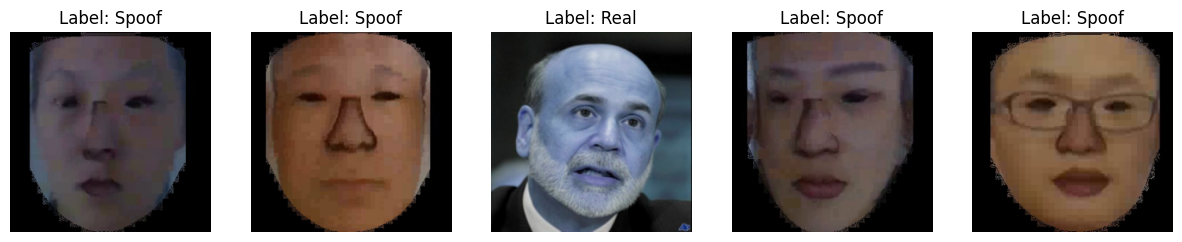

Validation Set (CelebA + LCC FASD + CASIA-SURF):


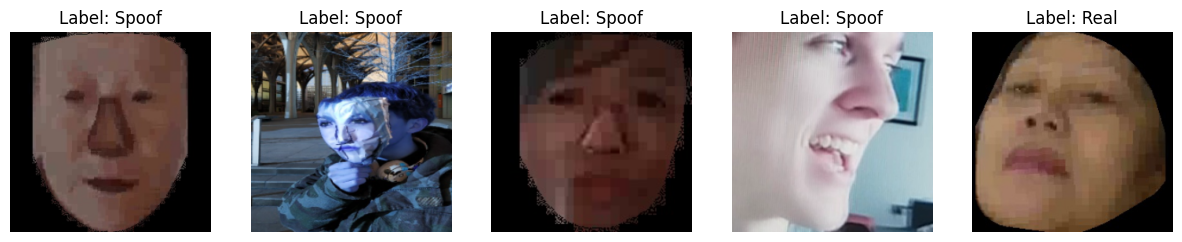

Test Set (RECOD):


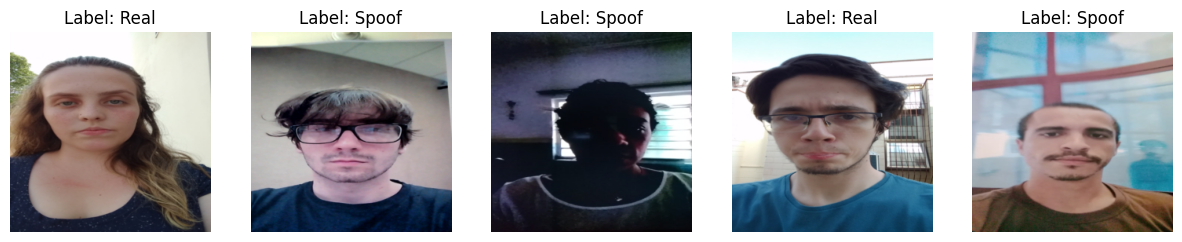

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset One - CelebA Dataset from NPZ file
class CelebADataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data = np.load(data_path)
        self.X = self.data['arr_0']
        self.y = self.data['arr_1']
        self.transform = transform
        print(f"Loaded CelebA dataset with {len(self.y)} samples")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Dataset Two - Binary Dataset from Directories (RECOD)
class BinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for category in ["attack_cce", "attack_hp", "attack_print1", "attack_print2", "real"]:
            label = 0 if category.startswith("attack") else 1
            category_dir = os.path.join(root_dir, category)
            if os.path.exists(category_dir):
                for root, _, files in os.walk(category_dir):
                    for file in files:
                        if file.endswith((".jpg", ".png")):
                            self.data.append((os.path.join(root, file), label))
        
        print(f"Loaded Binary dataset with {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Dataset Three - LCC FASD Dataset
class SpoofDataset(Dataset):
    def __init__(self, root_dir, category, label, transform=None):
        self.root_dir = os.path.join(root_dir, category)
        self.transform = transform
        self.data = []
        self.label = label

        if os.path.exists(self.root_dir):
            for root, _, files in os.walk(self.root_dir):
                for file in files:
                    if file.endswith((".png", ".jpg")):
                        self.data.append(os.path.join(root, file))
        
        print(f"Loaded LCC FASD {category} dataset with {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.label, dtype=torch.long)

# Dataset Four - CASIA-SURF Dataset
class CASIADataset(Dataset):
    def __init__(self, dataset_path, txt_file_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.samples = []

        # Read the txt file and collect paths for images along with their labels
        with open(txt_file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 2:
                    color_path = parts[0]
                    label = int(parts[-1])
                    color_full_path = os.path.join(self.dataset_path, color_path)
                    if os.path.exists(color_full_path):
                        self.samples.append((color_full_path, label))

        print(f"Loaded CASIA-SURF dataset with {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_path, label = self.samples[idx]
        image = Image.open(color_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Define the transforms
resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load all datasets
def load_all_datasets():
    # Load the CelebA dataset (for training)
    celebA_dataset = CelebADataset('anti_spoofing_data_224.npz', transform=resize_transform)

    # Load the Binary dataset (RECOD) - will be used for testing
    binary_dataset = BinaryDataset(
        "/media/pria/New Volume/Spoofing/Datasets/2020-plosone-recod-mpad/",
        transform=resize_transform
    )

    # Load the LCC FASD dataset (real and spoof)
    lcc_fasd_real = SpoofDataset(
        root_dir="/media/pria/New Volume/Spoofing/Datasets/LCC_FASD_CASIA/lcc-fasd-casia/LCC_FASD/LCC_FASD_training",
        category="real",
        label=1,
        transform=resize_transform
    )
    lcc_fasd_spoof = SpoofDataset(
        root_dir="/media/pria/New Volume/Spoofing/Datasets/LCC_FASD_CASIA/lcc-fasd-casia/LCC_FASD/LCC_FASD_training",
        category="spoof",
        label=0,
        transform=resize_transform
    )

    # Load CASIA-SURF dataset
    casia_dataset = CASIADataset(
        dataset_path="/media/pria/New Volume/Spoofing/Datasets/CASIA-SURF-Challenge/",
        txt_file_path="/media/pria/New Volume/Spoofing/Datasets/CASIA-SURF-Challenge/train_list.txt",
        transform=resize_transform
    )

    return celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset

def create_data_loaders(celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset):
    # Combine CelebA, LCC FASD, and CASIA-SURF for training/validation
    combined_train_dataset = ConcatDataset([
        celebA_dataset,    # CelebA
        lcc_fasd_real,    # LCC FASD (real)
        lcc_fasd_spoof,   # LCC FASD (spoof)
        casia_dataset      # CASIA-SURF
    ])

    # Split combined dataset into training and validation sets
    train_indices, val_indices = train_test_split(
        list(range(len(combined_train_dataset))),
        test_size=0.2,
        random_state=42
    )

    # Create subsets for train and validation
    train_dataset = Subset(combined_train_dataset, train_indices)
    val_dataset = Subset(combined_train_dataset, val_indices)

    # Use RECOD (Binary) dataset as test set
    test_dataset = binary_dataset

    # Create DataLoaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

# Displaying sample images
def show_images(dataloader, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for idx, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).cpu().numpy()
        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {'Real' if label.item() == 1 else 'Spoof'}")
        axes[idx].axis('off')
    plt.show()




# Load datasets and create data loaders
print("Loading datasets...")
celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset = load_all_datasets()

print("Creating data loaders...")
train_loader, val_loader, test_loader = create_data_loaders(
    celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset
)

# Show dataset statistics and sample images
print("\nDataset Statistics:")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples (RECOD): {len(test_loader.dataset)}")

# Display sample images
print("\nShowing sample images:")
print("Training Set (CelebA + LCC FASD + CASIA-SURF):")
show_images(train_loader)
print("Validation Set (CelebA + LCC FASD + CASIA-SURF):")
show_images(val_loader)
print("Test Set (RECOD):")
show_images(test_loader)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import os
import json

# Directory to save model and7logs
save_path = '../models/trial97'
os.makedirs(save_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleResNetModel(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(SimpleResNetModel, self).__init__()
        # Load ResNet-18 with pretrained weights
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        
        # Replace the final fully connected layer to match the number of classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = SimpleResNetModel(pretrained=True).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # Set as needed
best_val_accuracy = 0.0
train_log = []

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        train_correct += (predictions == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            predictions = torch.round(torch.sigmoid(outputs))
            valid_correct += (predictions == labels).sum().item()

            # Calculate true positives, true negatives, false positives, and false negatives
            for pred, label in zip(predictions, labels):
                if label == 1 and pred == 1:
                    true_positives += 1
                elif label == 1 and pred == 0:
                    false_negatives += 1
                elif label == 0 and pred == 1:
                    false_positives += 1
                else:
                    true_negatives += 1

    valid_loss /= len(val_loader.dataset)
    valid_accuracy = valid_correct / len(val_loader.dataset)

    # Save the model with the best validation accuracy
    if valid_accuracy > best_val_accuracy:
        best_val_accuracy = valid_accuracy
        torch.save(model.state_dict(), os.path.join(save_path, f'best_model.pth'))

    # Calculate APCER, BPCER, ACER, HTER, and EER
    try:
        apcer = false_positives / (false_positives + true_negatives)
        bpcer = false_negatives / (false_negatives + true_positives)
        acer = (apcer + bpcer) / 2
        hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        eer = bpcer  # Assuming the threshold is set to achieve EER
    except ZeroDivisionError:
        apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

    epoch_log = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'valid_loss': valid_loss,
        'valid_accuracy': valid_accuracy,
        'apcer': apcer,
        'bpcer': bpcer,
        'acer': acer,
        'hter': hter,
        'eer': eer
    }
    train_log.append(epoch_log)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
    print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")

# Save the training log
with open(os.path.join(save_path, 'train_log.json'), 'w') as f:
    json.dump(train_log, f, indent=4)


Validation Epoch 1/10: 100%|██████████████████| 301/301 [09:41<00:00,  1.93s/it]


Epoch 1/10
Train Loss: 0.1102, Train Accuracy: 0.9593
Valid Loss: 0.1626, Valid Accuracy: 0.9384
APCER: 0.0014, BPCER: 0.1891, ACER: 0.0952, HTER: 0.0616, EER: 0.1891


Validation Epoch 2/10: 100%|██████████████████| 301/301 [09:43<00:00,  1.94s/it]


Epoch 2/10
Train Loss: 0.0577, Train Accuracy: 0.9794
Valid Loss: 0.0595, Valid Accuracy: 0.9793
APCER: 0.0112, BPCER: 0.0409, ACER: 0.0260, HTER: 0.0207, EER: 0.0409


Validation Epoch 3/10: 100%|██████████████████| 301/301 [09:42<00:00,  1.94s/it]


Epoch 3/10
Train Loss: 0.0453, Train Accuracy: 0.9833
Valid Loss: 0.0808, Valid Accuracy: 0.9750
APCER: 0.0146, BPCER: 0.0470, ACER: 0.0308, HTER: 0.0250, EER: 0.0470


Validation Epoch 4/10: 100%|██████████████████| 301/301 [09:37<00:00,  1.92s/it]


Epoch 4/10
Train Loss: 0.0337, Train Accuracy: 0.9875
Valid Loss: 0.0448, Valid Accuracy: 0.9825
APCER: 0.0204, BPCER: 0.0114, ACER: 0.0159, HTER: 0.0175, EER: 0.0114


Validation Epoch 5/10: 100%|██████████████████| 301/301 [08:56<00:00,  1.78s/it]


Epoch 5/10
Train Loss: 0.0284, Train Accuracy: 0.9896
Valid Loss: 0.0272, Valid Accuracy: 0.9901
APCER: 0.0080, BPCER: 0.0139, ACER: 0.0110, HTER: 0.0099, EER: 0.0139


Validation Epoch 6/10: 100%|██████████████████| 301/301 [08:14<00:00,  1.64s/it]


Epoch 6/10
Train Loss: 0.0269, Train Accuracy: 0.9910
Valid Loss: 0.2958, Valid Accuracy: 0.9456
APCER: 0.0017, BPCER: 0.1657, ACER: 0.0837, HTER: 0.0544, EER: 0.1657


Validation Epoch 7/10: 100%|██████████████████| 301/301 [08:52<00:00,  1.77s/it]


Epoch 7/10
Train Loss: 0.0204, Train Accuracy: 0.9930
Valid Loss: 0.0277, Valid Accuracy: 0.9895
APCER: 0.0029, BPCER: 0.0266, ACER: 0.0148, HTER: 0.0105, EER: 0.0266


Validation Epoch 8/10: 100%|██████████████████| 301/301 [09:21<00:00,  1.87s/it]


Epoch 8/10
Train Loss: 0.0182, Train Accuracy: 0.9937
Valid Loss: 0.0325, Valid Accuracy: 0.9893
APCER: 0.0018, BPCER: 0.0295, ACER: 0.0157, HTER: 0.0107, EER: 0.0295


Validation Epoch 9/10: 100%|██████████████████| 301/301 [09:33<00:00,  1.91s/it]


Epoch 9/10
Train Loss: 0.0156, Train Accuracy: 0.9942
Valid Loss: 0.0273, Valid Accuracy: 0.9917
APCER: 0.0006, BPCER: 0.0247, ACER: 0.0126, HTER: 0.0083, EER: 0.0247


Validation Epoch 10/10: 100%|█████████████████| 301/301 [09:12<00:00,  1.84s/it]

Epoch 10/10
Train Loss: 0.0139, Train Accuracy: 0.9951
Valid Loss: 0.0320, Valid Accuracy: 0.9892
APCER: 0.0094, BPCER: 0.0139, ACER: 0.0117, HTER: 0.0108, EER: 0.0139


## Evalution

## Train set evalution

/tmp/ipykernel_1805149/1450234165.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
Evaluating Tra


Results for Training Set:
Loss: 0.0130, Accuracy: 0.9951
APCER: 0.0000, BPCER: 0.0155, ACER: 0.0078, HTER: 0.0049, EER: 0.0155

Classification Report:
              precision    recall  f1-score   support

      Attack       0.99      1.00      1.00     26248
        Real       1.00      0.98      0.99     12161

    accuracy                           1.00     38409
   macro avg       1.00      0.99      0.99     38409
weighted avg       1.00      1.00      1.00     38409

Confusion Matrix:
[[26247     1]
 [  189 11972]]


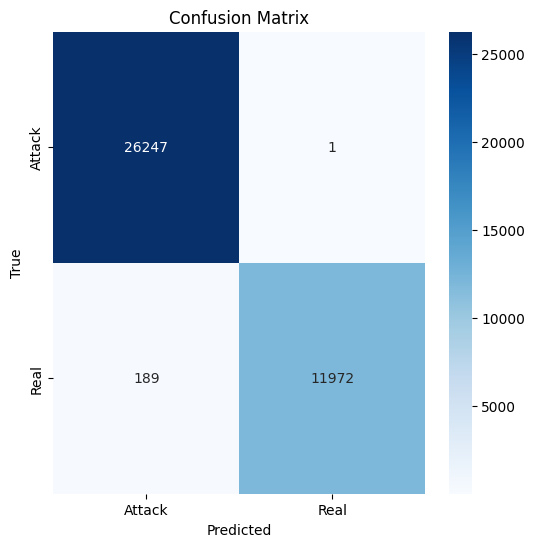


Visualizing predictions (Predicted vs Ground Truth):


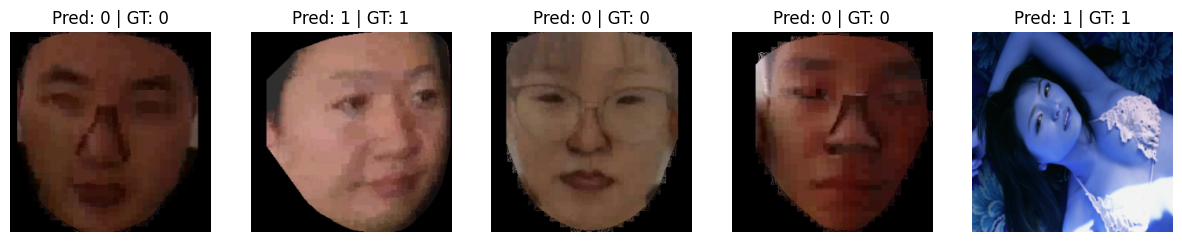

In [3]:
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Directory where the model is saved
save_path = '../models/trial97'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = SimpleResNetModel(pretrained=True).to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to evaluate loader and visualize predictions
def evaluate_loader(loader, loader_name="Dataset", num_images_to_show=5):
    correct = 0
    total = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    eval_loss = 0.0

    all_preds = []
    all_labels = []
    
    images_to_visualize = []
    pred_labels_to_visualize = []
    gt_labels_to_visualize = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating {loader_name}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
            outputs = model(images)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * images.size(0)

            predictions = torch.round(torch.sigmoid(outputs))
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Visualize some images
            if len(images_to_visualize) < num_images_to_show:
                images_to_visualize.extend(images.cpu()[:num_images_to_show - len(images_to_visualize)])
                pred_labels_to_visualize.extend(predictions.cpu()[:num_images_to_show - len(pred_labels_to_visualize)])
                gt_labels_to_visualize.extend(labels.cpu()[:num_images_to_show - len(gt_labels_to_visualize)])

            # Calculate true positives, true negatives, false positives, and false negatives
            for pred, label in zip(predictions, labels):
                if label == 1 and pred == 1:
                    true_positives += 1
                elif label == 1 and pred == 0:
                    false_negatives += 1
                elif label == 0 and pred == 1:
                    false_positives += 1
                else:
                    true_negatives += 1

    # Calculate metrics
    eval_loss /= total
    accuracy = correct / total

    # Calculate APCER, BPCER, ACER, HTER, and EER
    try:
        apcer = false_positives / (false_positives + true_negatives)
        bpcer = false_negatives / (false_negatives + true_positives)
        acer = (apcer + bpcer) / 2
        hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        eer = bpcer  # Assuming the threshold is set to achieve EER
    except ZeroDivisionError:
        apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

    # Print out the results for the current loader
    print(f"\nResults for {loader_name}:")
    print(f"Loss: {eval_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Attack', 'Real']))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, class_names=['Attack', 'Real'])

    # Visualize a few images with predictions
    print("\nVisualizing predictions (Predicted vs Ground Truth):")
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 15))
    for idx, (img, pred_label, gt_label) in enumerate(zip(images_to_visualize, pred_labels_to_visualize, gt_labels_to_visualize)):
        img = img.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C) for plotting
        axes[idx].imshow(img)
        axes[idx].set_title(f"Pred: {int(pred_label.item())} | GT: {int(gt_label.item())}")
        axes[idx].axis('off')
    plt.show()

# Evaluate on all three loaders (training, validation, and test)

# 1. Evaluate on train_loader (Real vs Spoof for training set)
evaluate_loader(train_loader, loader_name="Training Set", num_images_to_show=5)



## val set eval

Evaluating Validation Set: 100%|██████████████| 301/301 [09:28<00:00,  1.89s/it]



Results for Validation Set:
Loss: 0.0273, Accuracy: 0.9917
APCER: 0.0006, BPCER: 0.0247, ACER: 0.0126, HTER: 0.0083, EER: 0.0247

Classification Report:
              precision    recall  f1-score   support

      Attack       0.99      1.00      0.99      6520
        Real       1.00      0.98      0.99      3083

    accuracy                           0.99      9603
   macro avg       0.99      0.99      0.99      9603
weighted avg       0.99      0.99      0.99      9603

Confusion Matrix:
[[6516    4]
 [  76 3007]]


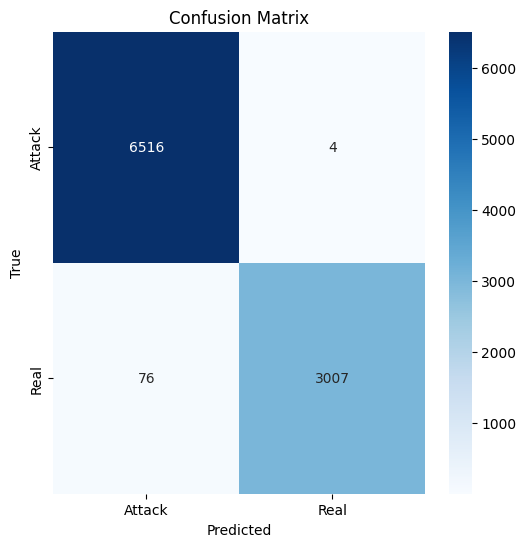


Visualizing predictions (Predicted vs Ground Truth):


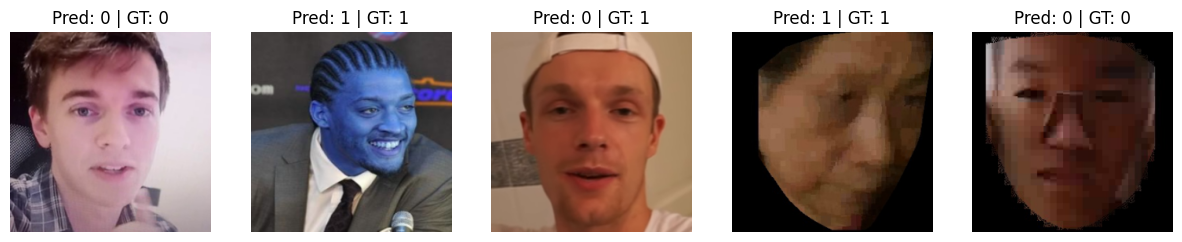

In [4]:
# 2. Evaluate on val_loader (Real vs Spoof for validation set)
evaluate_loader(val_loader, loader_name="Validation Set", num_images_to_show=5)




## Test set Eval (Cross dataset)

Evaluating Test Set: 100%|████████████████| 4500/4500 [4:12:27<00:00,  3.37s/it]



Results for Test Set:
Loss: 0.7905, Accuracy: 0.7916
APCER: 0.0721, BPCER: 0.7534, ACER: 0.4128, HTER: 0.2084, EER: 0.7534

Classification Report:
              precision    recall  f1-score   support

      Attack       0.83      0.93      0.88    115200
        Real       0.46      0.25      0.32     28800

    accuracy                           0.79    144000
   macro avg       0.65      0.59      0.60    144000
weighted avg       0.76      0.79      0.77    144000

Confusion Matrix:
[[106890   8310]
 [ 21697   7103]]


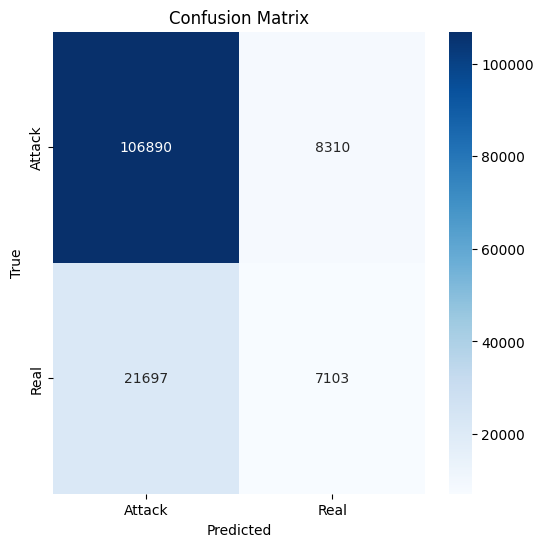


Visualizing predictions (Predicted vs Ground Truth):


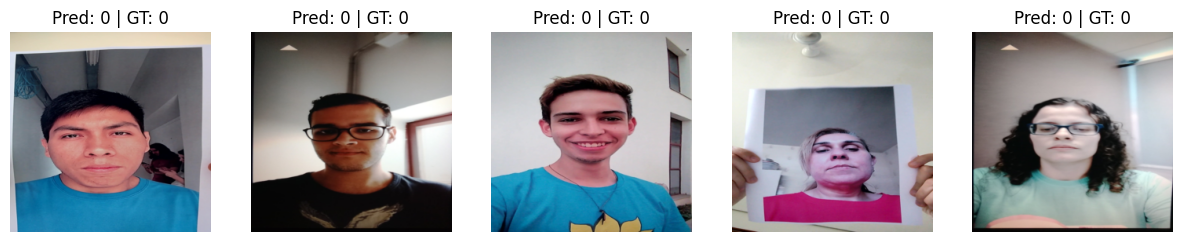

In [5]:
# 3. Evaluate on test_loader (Real vs Spoof for test set)
evaluate_loader(test_loader, loader_name="Test Set", num_images_to_show=5)